In [23]:
import json
from urllib import parse
import pandas as pd
import sqlite3
import numpy as np
from matplotlib import colors, cm, pyplot as plt

In [24]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [25]:
# specify the cuboid to visualise
RUN_NAME = 'YHE114_01_Slot1-1_1_3008'
CONVERTED_DB = '/data/experiments/YHE/converted-databases/exp-YHE-run-{}-converted.sqlite'.format(RUN_NAME)

In [180]:
estimated_mono_mz = 608.2654177475179
estimated_scan_apex = 730.7343765357679
estimated_rt_apex = 737.0740854292187

feature_region_mz_lower = 608.2623764204292
feature_region_mz_upper=611.7802015746065
scan_lower=703.1266804086576
scan_upper=758.3420726628781
rt_lower=674.3033902951571
rt_upper=799.8447805632803

In [181]:
feature_region_mz_lower_vis = feature_region_mz_lower - 0.5
feature_region_mz_upper_vis = feature_region_mz_upper + 0.5

In [182]:
db_conn = sqlite3.connect(CONVERTED_DB)
raw_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_type == {}".format(feature_region_mz_lower_vis, feature_region_mz_upper_vis, scan_lower, scan_upper, rt_lower, rt_upper, FRAME_TYPE_MS1), db_conn)
db_conn.close()

In [183]:
raw_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
0,5684,607.773010,724,207,674.475746
1,5684,607.773010,735,58,674.475746
2,5761,607.773010,735,153,683.255315
3,5838,607.773011,737,86,692.036434
4,5959,607.773013,729,120,705.833450


In [184]:
db_conn = sqlite3.connect(CONVERTED_DB)
frame_ids_df = pd.read_sql_query("select Id,Time from frame_properties where Time >= {} and Time <= {} and MsMsType == {} order by Time".format(rt_lower, rt_upper, FRAME_TYPE_MS1), db_conn)
db_conn.close()

In [185]:
frame_ids_l = frame_ids_df.Id.to_list()

In [186]:
colour_map = plt.get_cmap('rainbow')
norm = colors.LogNorm(vmin=1, vmax=1000, clip=True)  # aiming to get good colour variation in the lower range, and clipping everything else

In [187]:
# calculate the colour to represent the intensity
colours_l = []
for i in raw_df.intensity.unique():
    colours_l.append((i, colour_map(norm(i), bytes=False)[:3]))
colours_df = pd.DataFrame(colours_l, columns=['intensity','colour'])
raw_colour_df = pd.merge(raw_df, colours_df, how='left', left_on=['intensity'], right_on=['intensity'])

In [188]:
frames_l = []
for frame_id in frame_ids_l:
    frames_l.append(raw_colour_df[raw_colour_df.frame_id == frame_id])

In [189]:
len(frames_l)

100

In [190]:
columns = 2
rows = int(len(frames_l) / columns)
rows

50

In [191]:
if len(frames_l) % columns != 0:
    rows += 1

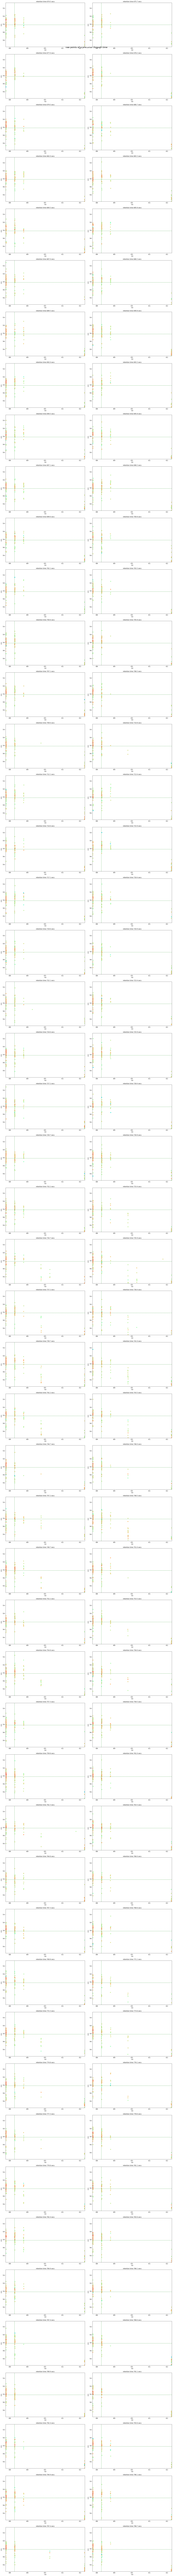

In [192]:
f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(rows * 6)
f.set_figwidth(20)
f.suptitle('raw points of a precursor through time\n', fontsize=18)

# turn off the axes if the last row is incomplete
if len(frames_l) % columns != 0:
    axarr[-1, -1].axis('off')

plt.margins(0.06)

for row_idx,frame_df in enumerate(frames_l):
    r = int(row_idx / 2)
    c = row_idx % 2
    ax = axarr[r,c]  # row, column

    retention_time = frame_ids_df.iloc[row_idx].Time
    ax.set_title('retention time {} secs'.format(round(retention_time,1)))

    ax.scatter(frame_df.mz, frame_df.scan, c=frame_df.colour)
    
    ax.axvline(estimated_mono_mz, color='green', lw=1.0, ls='-.')
    ax.axhline(estimated_scan_apex, color='green', lw=1.0, ls='-.')

    # set up axes
    ax.set_xlim((feature_region_mz_lower_vis,feature_region_mz_upper_vis))
    ax.set_ylim((scan_upper,scan_lower))
    ax.set_xlabel('m/z')
    ax.set_ylabel('CCS')

plt.show()

In [156]:
CARBON_MASS_DIFFERENCE = 1.003355

In [174]:
MZ_TOLERANCE_PPM = 10  # +/- this amount
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4
MS1_PEAK_DELTA = estimated_mono_mz * MZ_TOLERANCE_PERCENT / 100

In [175]:
charge = 2
isotope_idx = 2

In [176]:
expected_spacing_mz = CARBON_MASS_DIFFERENCE / charge

In [177]:
estimated_isotope_midpoint = estimated_mono_mz + (isotope_idx * expected_spacing_mz)
isotope_mz_lower = estimated_isotope_midpoint - MS1_PEAK_DELTA
isotope_mz_upper = estimated_isotope_midpoint + MS1_PEAK_DELTA

In [178]:
isotope_raw_points_df = raw_df[(raw_df.mz >= isotope_mz_lower) & (raw_df.mz <= isotope_mz_upper)]

In [179]:
isotope_raw_points_df

,frame_id,mz,scan,intensity,retention_time_secs
